https://youtu.be/UEoPJKJ_d3k


## TUTORIAL 2: DATA EXPLORATION & UNDERSTANDING

GOAL:
Systematically explore organoid feature datasets to understand:
- Data structure and hierarchy (Batch → Sample → Well → Field → Cell)
- Data quality (missing values, outliers, data types)
- Feature distributions and relationships
- Differences between datasets

This foundational exploration ensures we understand our data before any
hypothesis testing or modeling. We'll work with real published data from
Ong et al., Nature Methods 2025.

DATASET LOCATION: All Excel files are in a single directory


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# PART 1: LOADING AND STRUCTURE





### Load datasets

Let's start by loading the datasets. We're loading all downloaded Excel files
because we don't yet know which file contains what type of useful information.
Each Excel file may have multiple sheets, so we'll explore the structure of
each file systematically.

In [ ]:
def load_all_excel_files(data_dir="data"):
    """
    Load all Excel files from the data directory and return a dictionary
    containing all sheets from all files.

    Returns:
        dict: {filename: {sheet_name: dataframe}}
    """
    data_path = Path(data_dir)
    excel_files = list(data_path.glob("*.xlsx")) + list(data_path.glob("*.xls"))

    all_data = {}

    for file_path in excel_files:
        filename = file_path.stem  # Get filename without extension
        print(f"\n{'='*70}")
        print(f"Loading: {file_path.name}")
        print(f"{'='*70}")

        try:
            # Load all sheets from the Excel file
            excel_file = pd.ExcelFile(file_path)
            sheet_names = excel_file.sheet_names
            print(f"Found {len(sheet_names)} sheet(s): {sheet_names}")

            all_data[filename] = {}

            for sheet_name in sheet_names:
                df = pd.read_excel(file_path, sheet_name=sheet_name)
                all_data[filename][sheet_name] = df
                print(
                    f"  - Sheet '{sheet_name}': {df.shape[0]} rows × {df.shape[1]} columns"
                )

        except Exception as e:
            print(f"Error loading {file_path.name}: {str(e)}")

    return all_data


# Execute: Load all datasets
all_datasets = load_all_excel_files("/content/drive/MyDrive/ColabNotebooks/data/3D_Organoid_Analysis")
print(f"\n✓ Loaded {len(all_datasets)} Excel files successfully")


Loading: Fig-4-41592_2025_2685_MOESM11_ESM.xlsx
Found 1 sheet(s): ['Cell statistics']
  - Sheet 'Cell statistics': 1784 rows × 22 columns

Loading: Fig-3-Extended-41592_2025_2685_MOESM13_ESM.xlsx
Found 1 sheet(s): ['IoU_stats']
  - Sheet 'IoU_stats': 7788 rows × 15 columns

Loading: Fig-2-41592_2025_2685_MOESM9_ESM.xlsx
Found 1 sheet(s): ['Cell statistics']
  - Sheet 'Cell statistics': 895 rows × 9 columns

Loading: Table-3-Extended-41592_2025_2685_MOESM14_ESM.xlsx
Found 2 sheet(s): ['speed', 'Sheet1']
  - Sheet 'speed': 70 rows × 4 columns
  - Sheet 'Sheet1': 0 rows × 0 columns

Loading: Fig-3-41592_2025_2685_MOESM10_ESM.xlsx
Found 1 sheet(s): ['Cell statistics']
  - Sheet 'Cell statistics': 2062 rows × 11 columns

Loading: Fig-5-41592_2025_2685_MOESM12_ESM.xlsx
Found 2 sheet(s): ['5a (blue)', '5b (grey)']
  - Sheet '5a (blue)': 1784 rows × 22 columns
  - Sheet '5b (grey)': 3071 rows × 34 columns

✓ Loaded 6 Excel files successfully


### File cleanup

We need to do minimal cleaning: skip empty sheets and remove empty columns.


In [ ]:
def clean_and_filter_datasets(all_data):
    """
    Clean loaded datasets by:
    - Skipping empty sheets
    - Removing completely empty columns

    Args:
        all_data: dict of {filename: {sheet_name: dataframe}}

    Returns:
        cleaned dict of datasets
    """
    cleaned_data = {}

    for filename, sheets in all_data.items():
        cleaned_data[filename] = {}

        for sheet_name, df in sheets.items():
            # Skip empty dataframes
            if df.shape[0] == 0:
                print(f"⚠ Skipping empty sheet: {filename} - {sheet_name}")
                continue

            # Remove completely empty columns (all NaN)
            df = df.dropna(axis=1, how="all")

            # Store cleaned dataframe
            cleaned_data[filename][sheet_name] = df

    return cleaned_data


# Execute: Clean the datasets
print(f"\n{'='*70}")
print("CLEANING DATASETS")
print(f"{'='*70}")
all_datasets = clean_and_filter_datasets(all_datasets)
print(f"\n✓ Cleaning complete")


CLEANING DATASETS
⚠ Skipping empty sheet: Table-3-Extended-41592_2025_2685_MOESM14_ESM - Sheet1

✓ Cleaning complete


### Explore the structure of each dataset


Now let's examine the structure of each dataset more carefully.

We want to understand the hierarchical organization: Batch → Sample → Well → Field → Cell.

This hierarchy is critical for proper statistical analysis later.


In [ ]:
def explore_dataset_structure(df, dataset_name):
    """
    Analyze the hierarchical structure of a dataset and identify
    organizational columns (Batch, Sample, Well, Field, etc.)

    Args:
        df: pandas DataFrame
        dataset_name: string identifier for the dataset
    """
    print(f"\n{'='*70}")
    print(f"EXPLORING STRUCTURE: {dataset_name}")
    print(f"{'='*70}")

    print(f"\nDataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")

    # Display first few rows
    #print(f"\nFirst 3 rows:")
    #print(df.head(3))

    # Identify potential hierarchy columns
    hierarchy_keywords = ["batch", "sample", "well", "field", "condition", "treatment"]
    hierarchy_cols = [
        col
        for col in df.columns
        if any(keyword in col.lower() for keyword in hierarchy_keywords)
    ]

    if hierarchy_cols:
        print(f"\n📊 HIERARCHY COLUMNS DETECTED:")
        for col in hierarchy_cols:
            unique_vals = df[col].nunique()
            print(f"  - {col}: {unique_vals} unique value(s)")
            if unique_vals <= 10:  # Show values if not too many
                # Get unique values and handle mixed types/NaN
                unique_values = df[col].dropna().unique()
                try:
                    # Try to sort if all values are comparable
                    if len(unique_values) > 0:
                        # Convert to string for safe sorting
                        sorted_values = sorted([str(v) for v in unique_values])
                        #print(f"    Values: {sorted_values}")
                except Exception as e:
                    # If sorting fails, just show unsorted
                    print(f"    Values: {[str(v) for v in unique_values]}")
    else:
        print("\n⚠ No obvious hierarchy columns detected")

    # Column data types
    print(f"\n📋 COLUMN DATA TYPES:")
    print(df.dtypes.value_counts())

    return hierarchy_cols


# Execute: Explore structure of each dataset
for filename, sheets in all_datasets.items():
    for sheet_name, df in sheets.items():
        dataset_identifier = f"{filename} - {sheet_name}"
        explore_dataset_structure(df, dataset_identifier)


EXPLORING STRUCTURE: Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics

Dataset dimensions: 1784 rows × 22 columns

📊 HIERARCHY COLUMNS DETECTED:
  - Batch: 1 unique value(s)
  - Sample: 8 unique value(s)
  - Well: 8 unique value(s)
  - Field: 1 unique value(s)

📋 COLUMN DATA TYPES:
float64    16
object      4
int64       2
Name: count, dtype: int64

EXPLORING STRUCTURE: Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats

Dataset dimensions: 7788 rows × 15 columns

⚠ No obvious hierarchy columns detected

📋 COLUMN DATA TYPES:
float64    6
int64      5
object     4
Name: count, dtype: int64

EXPLORING STRUCTURE: Fig-2-41592_2025_2685_MOESM9_ESM - Cell statistics

Dataset dimensions: 895 rows × 9 columns

📊 HIERARCHY COLUMNS DETECTED:
  - Batch: 1 unique value(s)
  - Sample: 1 unique value(s)
  - Well: 1 unique value(s)
  - Field: 4 unique value(s)
  - Condition: 1 unique value(s)

📋 COLUMN DATA TYPES:
object     5
float64    3
int64      1
Name: count, dtype: int64

EXPLORING STR

### Birdseye view of data

Let's create a summary inventory of all our datasets. This gives us a
bird's-eye view of what data we have available for analysis.


In [ ]:
def create_dataset_inventory(all_data):
    """
    Create a comprehensive inventory summarizing all datasets:
    - Number of rows (cells)
    - Number of columns (features)
    - Key organizational structure

    Returns:
        pandas DataFrame with inventory
    """
    inventory = []

    for filename, sheets in all_data.items():
        for sheet_name, df in sheets.items():
            # Count numeric vs non-numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

            # Identify unique wells/samples if present
            well_col = [col for col in df.columns if "well" in col.lower()]
            n_wells = df[well_col[0]].nunique() if well_col else "N/A"

            inventory.append(
                {
                    "File": filename,
                    "Sheet": sheet_name,
                    "Rows (Cells)": df.shape[0],
                    "Total Columns": df.shape[1],
                    "Numeric Features": len(numeric_cols),
                    "Non-Numeric Columns": len(non_numeric_cols),
                    "Unique Wells": n_wells,
                }
            )

    inventory_df = pd.DataFrame(inventory)
    return inventory_df


# Execute: Create and display inventory
inventory = create_dataset_inventory(all_datasets)
print(f"\n{'='*70}")
print("DATASET INVENTORY SUMMARY")
print(f"{'='*70}")
print(inventory.to_string(index=False))


DATASET INVENTORY SUMMARY
                                        File           Sheet  Rows (Cells)  Total Columns  Numeric Features  Non-Numeric Columns Unique Wells
           Fig-4-41592_2025_2685_MOESM11_ESM Cell statistics          1784             22                18                    4            8
  Fig-3-Extended-41592_2025_2685_MOESM13_ESM       IoU_stats          7788             15                11                    4          N/A
            Fig-2-41592_2025_2685_MOESM9_ESM Cell statistics           895              9                 4                    5            1
Table-3-Extended-41592_2025_2685_MOESM14_ESM           speed            70              4                 1                    3          N/A
           Fig-3-41592_2025_2685_MOESM10_ESM Cell statistics          2062             11                 6                    5            2
           Fig-5-41592_2025_2685_MOESM12_ESM       5a (blue)          1784             22                18              


# PART 2: DATA QUALITY ASSESSMENT


### Assess data quality


Before we can trust any analysis, we need to check data quality. We'll look for
missing values, check data types, and identify potential outliers. Missing data
can bias results, and outliers might represent real biology or technical artifacts.


In [ ]:
def assess_data_quality(df, dataset_name):
    """
    Perform comprehensive data quality checks:
    - Missing values
    - Data type consistency
    - Basic outlier detection

    Args:
        df: pandas DataFrame
        dataset_name: string identifier
    """
    print(f"\n{'='*70}")
    print(f"DATA QUALITY ASSESSMENT: {dataset_name}")
    print(f"{'='*70}")

    # 1. Missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame(
        {
            "Column": missing.index,
            "Missing_Count": missing.values,
            "Missing_Percent": missing_pct.values,
        }
    )
    missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values(
        "Missing_Percent", ascending=False
    )

    if len(missing_df) > 0:
        print(f"\n⚠ MISSING VALUES DETECTED:")
        print(missing_df.to_string(index=False))
    else:
        print(f"\n✓ No missing values detected")

    # 2. Check numeric columns for potential issues
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 0:
        print(f"\n📊 NUMERIC FEATURES SUMMARY:")
        print(f"Total numeric columns: {len(numeric_cols)}")

        # Check for columns with zero variance (all same value)
        zero_var_cols = [col for col in numeric_cols if df[col].std() == 0]
        if zero_var_cols:
            print(f"\n⚠ Columns with zero variance (constant values):")
            for col in zero_var_cols:
                print(f"  - {col}: value = {df[col].iloc[0]}")
        else:
            print("✓ All numeric columns have variance")

    # 3. Sample sizes per condition (if applicable)
    condition_cols = [
        col
        for col in df.columns
        if any(keyword in col.lower() for keyword in ["condition", "treatment", "well"])
    ]

    if condition_cols:
        print(f"\n📈 SAMPLE SIZES PER CONDITION:")
        for col in condition_cols[:2]:  # Show first 2 condition columns
            print(f"\n{col}:")
            print(df[col].value_counts().to_string())

    return missing_df


# Execute: Assess quality for each dataset
for filename, sheets in all_datasets.items():
    for sheet_name, df in sheets.items():
        dataset_identifier = f"{filename} - {sheet_name}"
        assess_data_quality(df, dataset_identifier)



DATA QUALITY ASSESSMENT: Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics

✓ No missing values detected

📊 NUMERIC FEATURES SUMMARY:
Total numeric columns: 18
✓ All numeric columns have variance

📈 SAMPLE SIZES PER CONDITION:

Well:
Well
A06    339
A02    258
A07    255
A04    232
A03    226
A01    202
A05    138
A09    134

DATA QUALITY ASSESSMENT: Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats

⚠ MISSING VALUES DETECTED:
     Column  Missing_Count  Missing_Percent
dice_global           3232        41.499743
        snr             24         0.308166

📊 NUMERIC FEATURES SUMMARY:
Total numeric columns: 11
✓ All numeric columns have variance

DATA QUALITY ASSESSMENT: Fig-2-41592_2025_2685_MOESM9_ESM - Cell statistics

✓ No missing values detected

📊 NUMERIC FEATURES SUMMARY:
Total numeric columns: 4
✓ All numeric columns have variance

📈 SAMPLE SIZES PER CONDITION:

Well:
Well
A01    895

Condition:
Condition
A1    895

DATA QUALITY ASSESSMENT: Table-3-Extended-41592_2025_2

### Check outliers


Let's look more closely at outliers in the numeric features. Outliers might
be real biological variation or they might be measurement errors. We'll use
the IQR (Interquartile Range) method to flag potential outliers.


In [ ]:
def detect_outliers_iqr(df, dataset_name, n_features_to_show=5):
    """
    Detect outliers using the IQR method (values beyond 1.5*IQR from quartiles)

    Args:
        df: pandas DataFrame
        dataset_name: string identifier
        n_features_to_show: number of features to display detailed outlier info
    """
    print(f"\n{'='*70}")
    print(f"OUTLIER DETECTION: {dataset_name}")
    print(f"{'='*70}")

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    outlier_summary = []

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        n_outliers = len(outliers)
        pct_outliers = (n_outliers / len(df)) * 100

        outlier_summary.append(
            {
                "Feature": col,
                "N_Outliers": n_outliers,
                "Percent_Outliers": pct_outliers,
                "Lower_Bound": lower_bound,
                "Upper_Bound": upper_bound,
            }
        )

    outlier_df = pd.DataFrame(outlier_summary)
    outlier_df = outlier_df[outlier_df["N_Outliers"] > 0].sort_values(
        "Percent_Outliers", ascending=False
    )

    if len(outlier_df) > 0:
        print(f"\n⚠ OUTLIERS DETECTED (IQR method):")
        print(f"\nTop {n_features_to_show} features with most outliers:")
        print(outlier_df.head(n_features_to_show).to_string(index=False))
    else:
        print("\n✓ No outliers detected using IQR method")

    return outlier_df


# Execute: Detect outliers for each dataset
for filename, sheets in all_datasets.items():
    for sheet_name, df in sheets.items():
        if df.shape[0] > 0:  # Only if dataframe is not empty
            dataset_identifier = f"{filename} - {sheet_name}"
            detect_outliers_iqr(df, dataset_identifier)



OUTLIER DETECTION: Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics

⚠ OUTLIERS DETECTED (IQR method):

Top 5 features with most outliers:
                                                      Feature  N_Outliers  Percent_Outliers   Lower_Bound   Upper_Bound
     Value of Default_ratio_density_normal_per_ripley_50.0_μm         121          6.782511     -0.325639      4.514514
              Value of Default_crystal_distance_ripley50.0_μm          71          3.979821     10.910844     42.393916
          Value of Default_nb_nuclei_neighbors_ripley_50.0_μm          66          3.699552    -21.254268     84.213041
            Value of Default_nb_nuclei_by_mm_3_ripley_50.0_μm          66          3.699552 -40592.662352 160835.060229
Value of Default_neighbors_average_distance_to_nuclei_50.0_μm          54          3.026906     30.419711     39.659411

OUTLIER DETECTION: Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats

⚠ OUTLIERS DETECTED (IQR method):

Top 5 features with most o

# PART 3: FEATURE DISTRIBUTIONS

### Visualize Distributions

Now let's visualize the distribution of numeric features. Understanding
distributions helps us choose appropriate statistical tests later and
reveals whether data is normal, skewed, or has multiple modes.


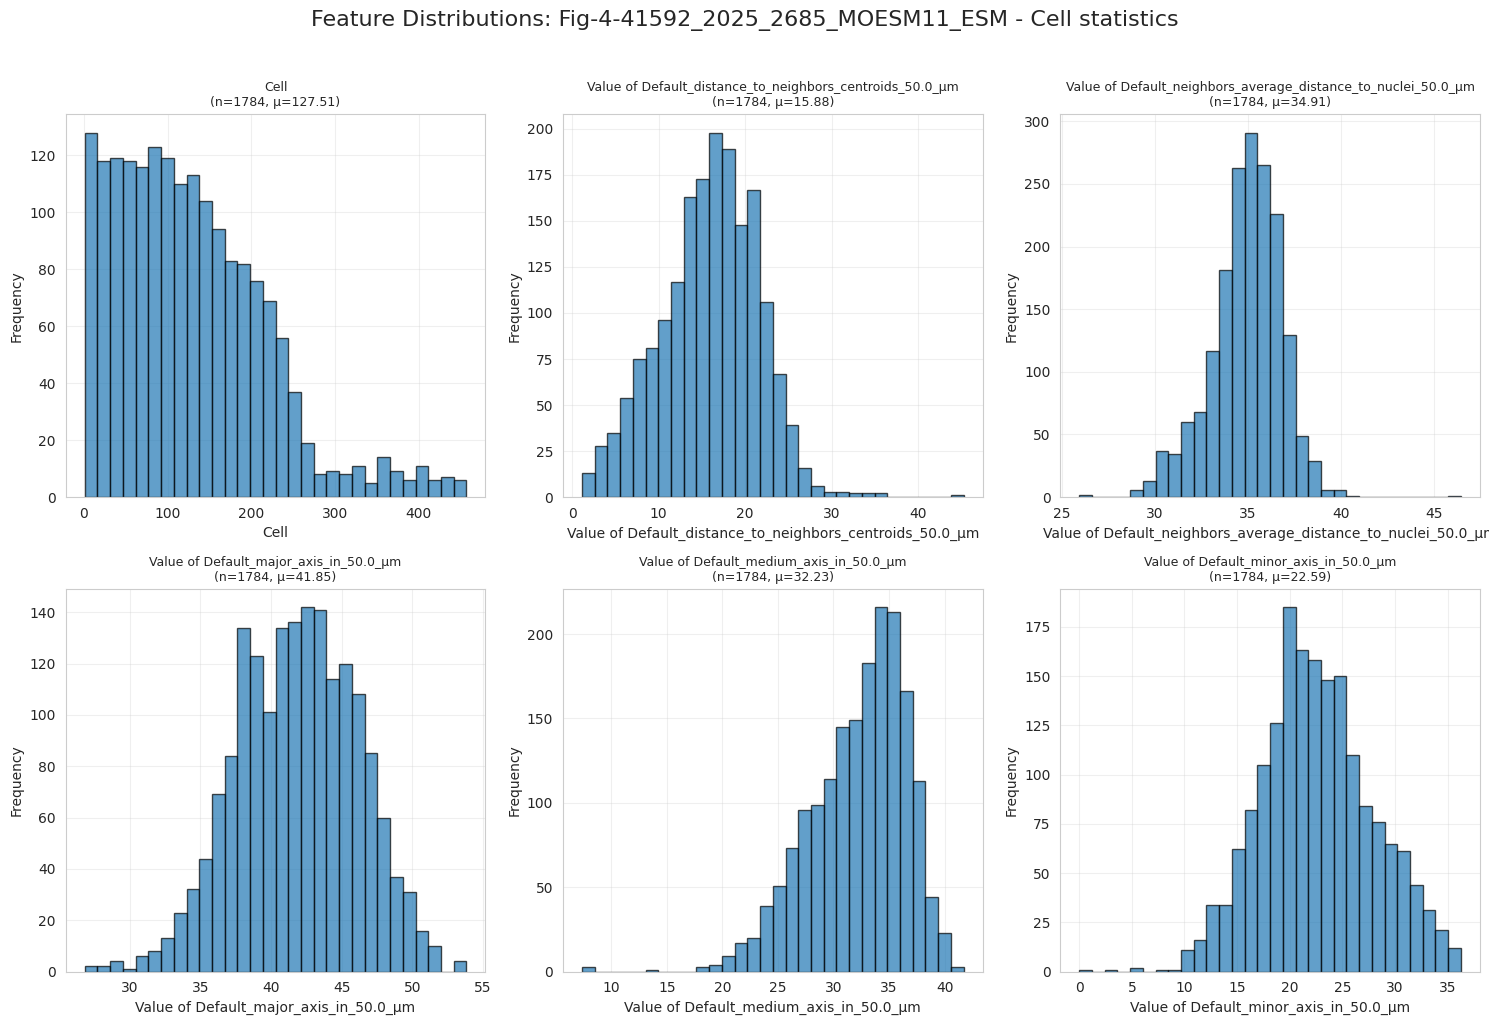


✓ Distribution plots saved for Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics


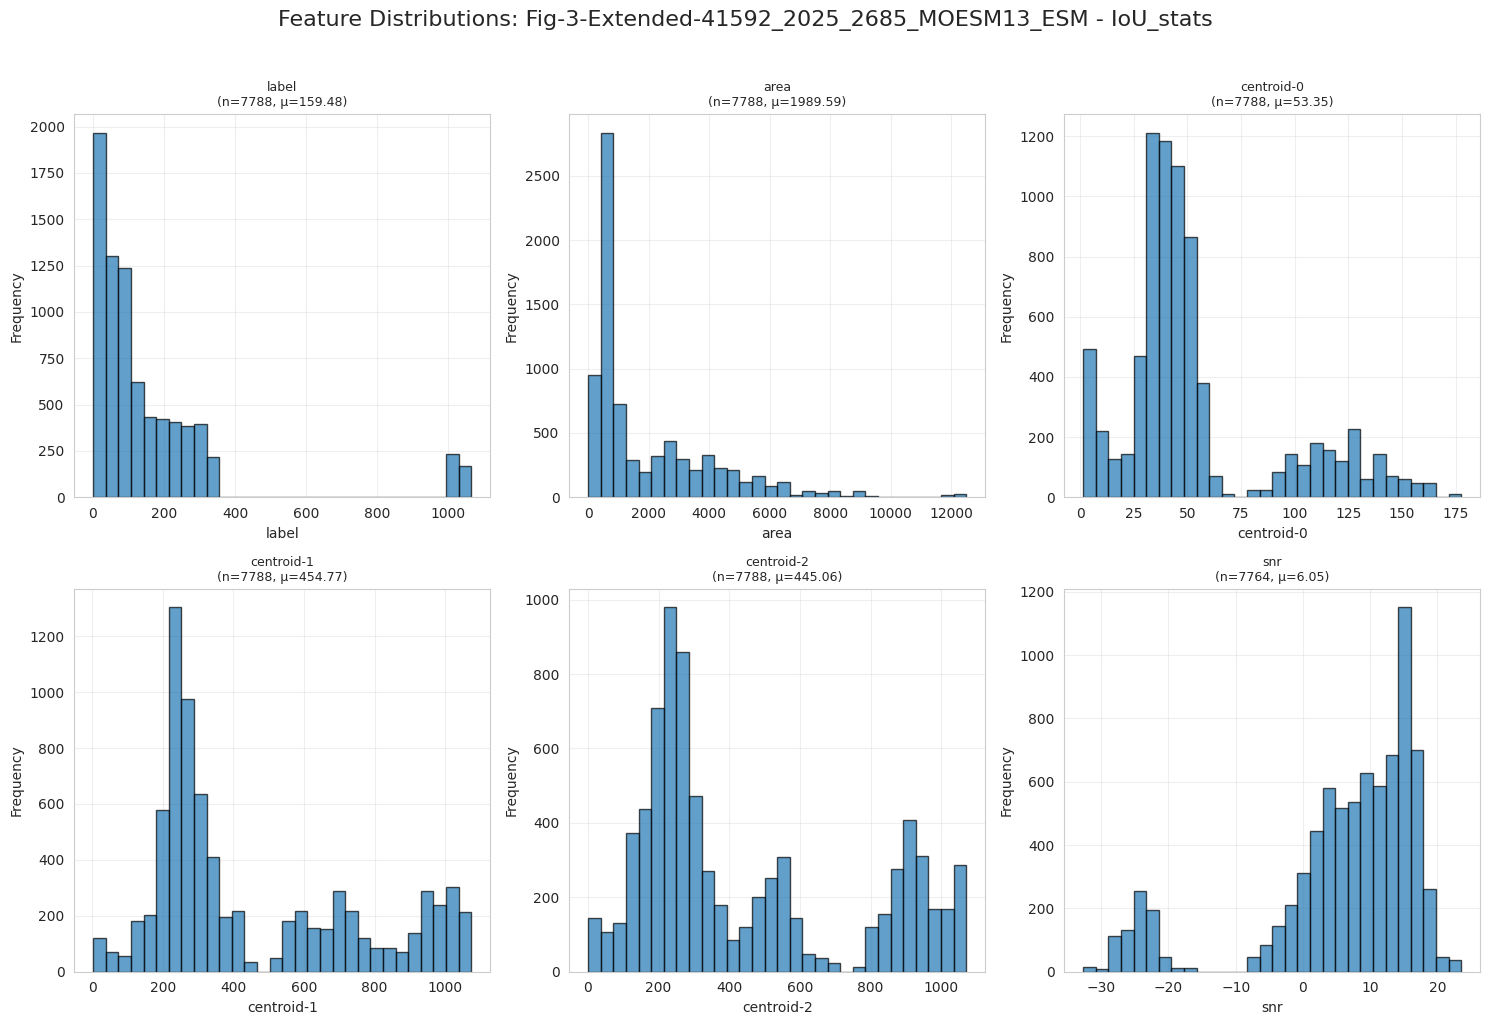


✓ Distribution plots saved for Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats


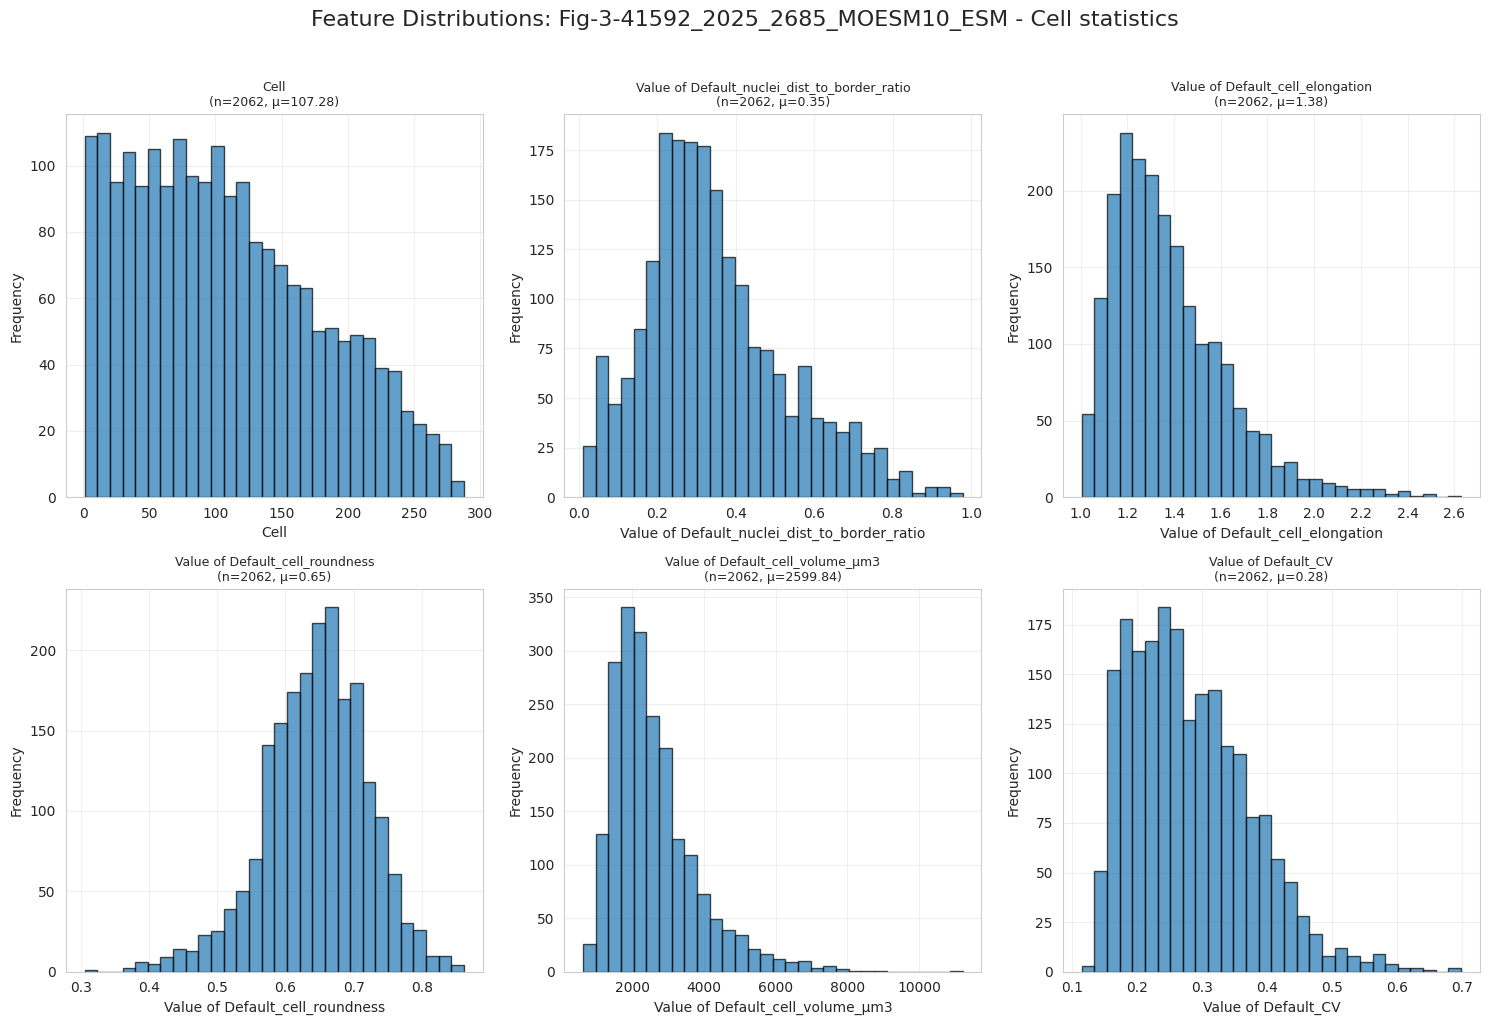


✓ Distribution plots saved for Fig-3-41592_2025_2685_MOESM10_ESM - Cell statistics


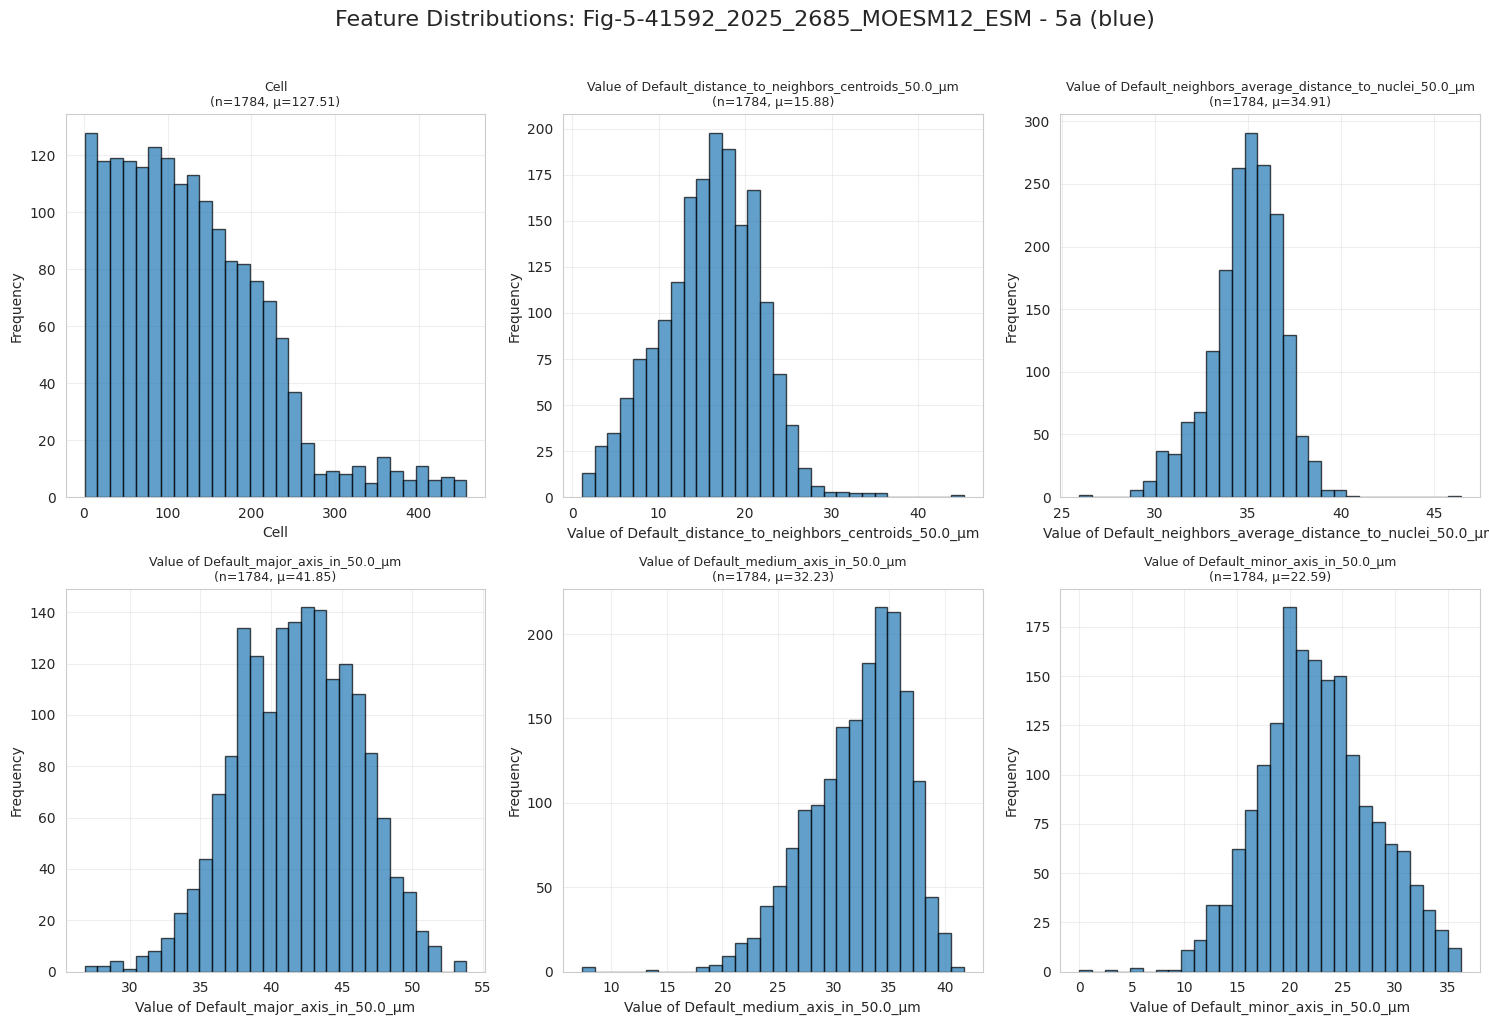


✓ Distribution plots saved for Fig-5-41592_2025_2685_MOESM12_ESM - 5a (blue)


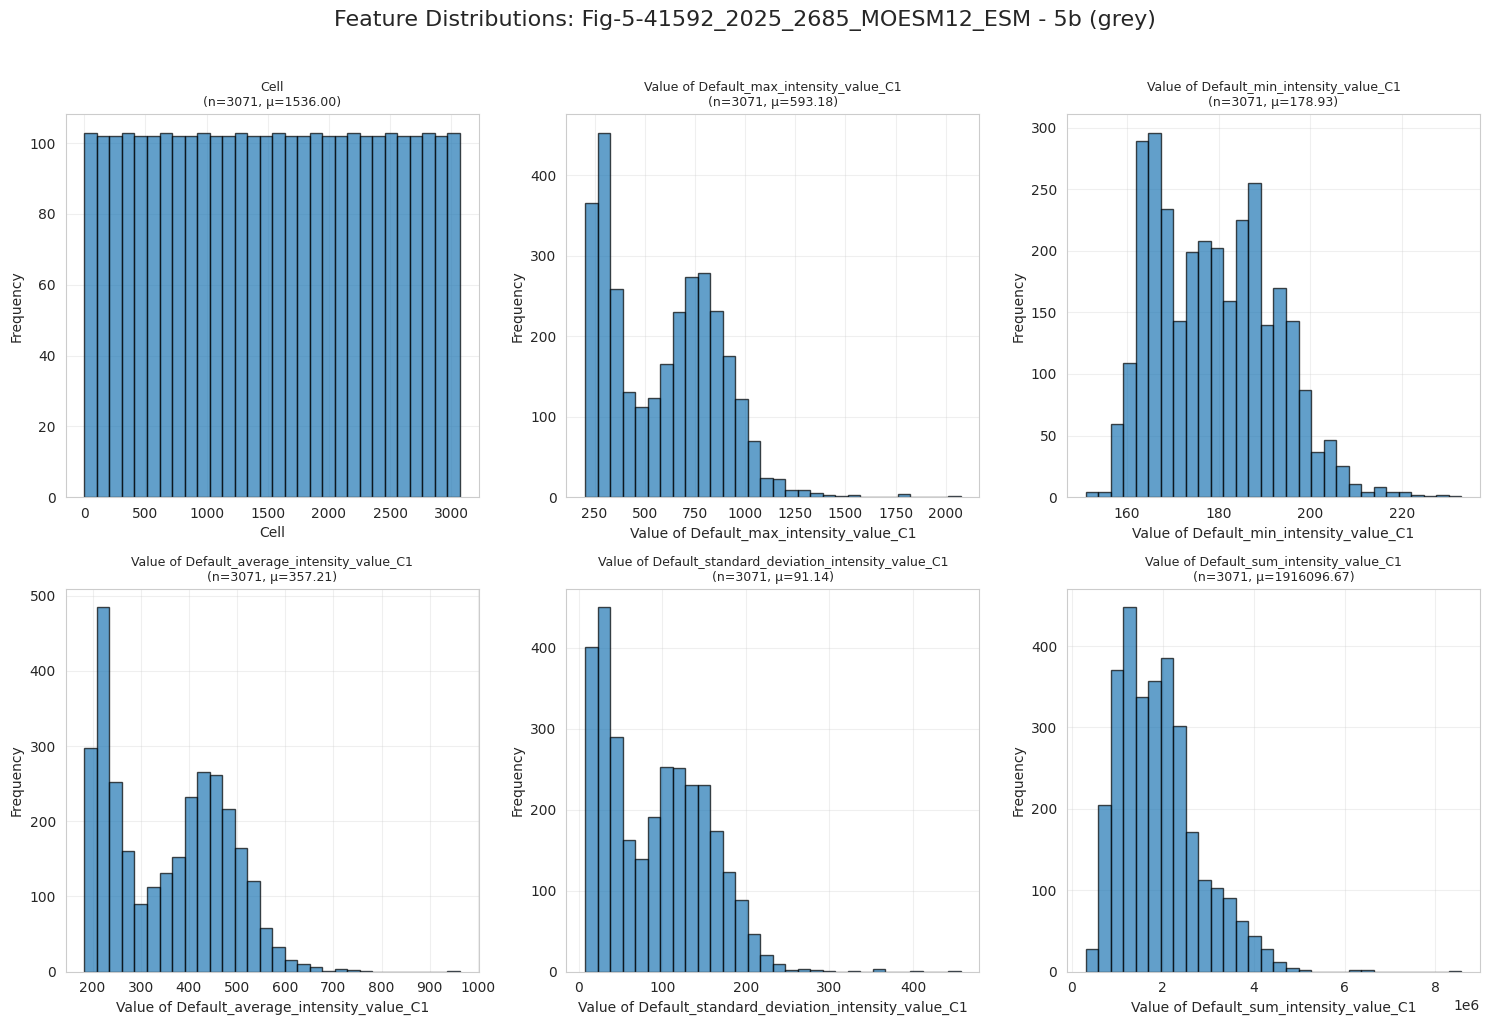


✓ Distribution plots saved for Fig-5-41592_2025_2685_MOESM12_ESM - 5b (grey)


In [ ]:
def plot_feature_distributions(df, dataset_name, max_features=6):
    """
    Create histogram plots for numeric features to visualize distributions

    Args:
        df: pandas DataFrame
        dataset_name: string identifier
        max_features: maximum number of features to plot
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Select features to plot (avoid plotting too many)
    features_to_plot = numeric_cols[:max_features]

    n_features = len(features_to_plot)
    n_rows = (n_features + 2) // 3  # 3 columns per row
    n_cols = min(3, n_features)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle(f"Feature Distributions: {dataset_name}", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    if n_features == 1:
        axes = [axes]
    elif n_features > 1:
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for idx, col in enumerate(features_to_plot):
        ax = axes[idx] if n_features > 1 else axes[0]

        # Remove infinite values and NaN for plotting
        data = df[col].replace([np.inf, -np.inf], np.nan).dropna()

        if len(data) > 0:
            ax.hist(data, bins=30, edgecolor="black", alpha=0.7)
            ax.set_xlabel(col, fontsize=10)
            ax.set_ylabel("Frequency", fontsize=10)
            ax.set_title(f"{col}\n(n={len(data)}, μ={data.mean():.2f})", fontsize=9)
            ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    #plt.savefig(f'distributions_{dataset_name.replace(" - ", "_").replace(" ", "_")}.png',dpi=150,bbox_inches="tight",)
    plt.show()

    print(f"\n✓ Distribution plots saved for {dataset_name}")


# Execute: Plot distributions for key datasets
# Let's focus on the main datasets we'll use in later tutorials
key_datasets = {
    "Fig-3": "osmotic stress comparison",
    "Fig-4": "spatial topology analysis",
    "Fig-5": "tumor heterogeneity",
}

for filename, sheets in all_datasets.items():
    # Check if this is one of our key datasets
    if any(key in filename for key in key_datasets.keys()):
        for sheet_name, df in sheets.items():
            if df.shape[0] > 0:  # Only if dataframe has data
                dataset_identifier = f"{filename} - {sheet_name}"
                plot_feature_distributions(df, dataset_identifier)


### Formal statistical evaluation


Let's also look at distribution statistics more formally. We'll check for
skewness and kurtosis, which tell us how far from normal our distributions are.


In [ ]:
def analyze_distribution_statistics(df, dataset_name):
    """
    Calculate skewness and kurtosis for numeric features to assess
    deviation from normal distribution

    Args:
        df: pandas DataFrame
        dataset_name: string identifier
    """
    from scipy import stats

    print(f"\n{'='*70}")
    print(f"DISTRIBUTION STATISTICS: {dataset_name}")
    print(f"{'='*70}")

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    dist_stats = []

    for col in numeric_cols:
        data = df[col].replace([np.inf, -np.inf], np.nan).dropna()

        if len(data) > 0:
            dist_stats.append(
                {
                    "Feature": col,
                    "Mean": data.mean(),
                    "Median": data.median(),
                    "Std": data.std(),
                    "Skewness": stats.skew(data),
                    "Kurtosis": stats.kurtosis(data),
                }
            )

    dist_df = pd.DataFrame(dist_stats)

    # Identify highly skewed features (|skewness| > 1)
    highly_skewed = dist_df[abs(dist_df["Skewness"]) > 1].sort_values(
        "Skewness", key=abs, ascending=False
    )

    if len(highly_skewed) > 0:
        print(f"\n⚠ HIGHLY SKEWED FEATURES (|skewness| > 1):")
        print(highly_skewed[["Feature", "Skewness"]].head(10).to_string(index=False))
    else:
        print("\n✓ No highly skewed features detected")

    return dist_df


# Execute: Analyze distribution statistics
for filename, sheets in all_datasets.items():
    if any(key in filename for key in ["Fig-3", "Fig-4", "Fig-5"]):
        for sheet_name, df in sheets.items():
            if df.shape[0] > 0:
                dataset_identifier = f"{filename} - {sheet_name}"
                analyze_distribution_statistics(df, dataset_identifier)


DISTRIBUTION STATISTICS: Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics

⚠ HIGHLY SKEWED FEATURES (|skewness| > 1):
                                                 Feature  Skewness
Value of Default_ratio_density_normal_per_ripley_50.0_μm 13.975580
         Value of Default_crystal_distance_ripley50.0_μm  8.591779
     Value of Default_nb_nuclei_neighbors_ripley_50.0_μm  1.072792
       Value of Default_nb_nuclei_by_mm_3_ripley_50.0_μm  1.072792

DISTRIBUTION STATISTICS: Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats

⚠ HIGHLY SKEWED FEATURES (|skewness| > 1):
   Feature  Skewness
   label_2  4.761601
     label  3.002620
    n_pred  2.816890
   density  1.872247
      area  1.691796
       snr -1.542486
centroid-0  1.271381

DISTRIBUTION STATISTICS: Fig-3-41592_2025_2685_MOESM10_ESM - Cell statistics

⚠ HIGHLY SKEWED FEATURES (|skewness| > 1):
                         Feature  Skewness
Value of Default_cell_volume_μm3  1.612091
Value of Default_cell_elongation  1.252401

# PART 4: RELATIONSHIPS BETWEEN FEATURES


### Feature relationships

Understanding how features relate to each other is crucial. Highly correlated
features might be redundant. Feature relationships can also reveal biological
mechanisms or technical artifacts.


In [ ]:
def calculate_correlation_matrix(df, dataset_name, threshold=0.7):
    """
    Calculate correlation matrix for numeric features and identify
    highly correlated pairs

    Args:
        df: pandas DataFrame
        dataset_name: string identifier
        threshold: correlation threshold to flag (default 0.7)
    """
    print(f"\n{'='*70}")
    print(f"FEATURE CORRELATIONS: {dataset_name}")
    print(f"{'='*70}")

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) < 2:
        print("\n⚠ Not enough numeric features for correlation analysis")
        return None

    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()

    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= threshold:
                high_corr_pairs.append(
                    {
                        "Feature_1": corr_matrix.columns[i],
                        "Feature_2": corr_matrix.columns[j],
                        "Correlation": corr_val,
                    }
                )

    if high_corr_pairs:
        print(f"\n⚠ HIGHLY CORRELATED FEATURE PAIRS (|r| ≥ {threshold}):")
        corr_df = pd.DataFrame(high_corr_pairs).sort_values(
            "Correlation", key=abs, ascending=False
        )
        print(corr_df.to_string(index=False))
    else:
        print(f"\n✓ No feature pairs with |correlation| ≥ {threshold}")

    return corr_matrix


# Execute: Calculate correlations for each dataset
correlation_matrices = {}
for filename, sheets in all_datasets.items():
    if any(key in filename for key in ["Fig-3", "Fig-4", "Fig-5"]):
        for sheet_name, df in sheets.items():
            if df.shape[0] > 0:
                dataset_identifier = f"{filename} - {sheet_name}"
                corr_matrix = calculate_correlation_matrix(df, dataset_identifier)
                if corr_matrix is not None:
                    correlation_matrices[dataset_identifier] = corr_matrix


FEATURE CORRELATIONS: Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics

⚠ HIGHLY CORRELATED FEATURE PAIRS (|r| ≥ 0.7):
                                                        Feature_1                                                         Feature_2  Correlation
                      Value of Default_n_nuclei_neighbors_50.0_μm                        Value of Default_nb_nuclei_by_mm_3_50.0_μm     1.000000
              Value of Default_nb_nuclei_neighbors_ripley_50.0_μm                 Value of Default_nb_nuclei_by_mm_3_ripley_50.0_μm     1.000000
                 Value of Default_ratio_minor_by_major_in_50.0_μm Value of Default_ratio_minor_X_minor_by_major_X_medium_in_50.0_μm     0.953939
                 Value of Default_ratio_minor_by_major_in_50.0_μm Value of Default_ratio_minor_X_medium_by_major_X_major_in_50.0_μm     0.944360
                Value of Default_ratio_minor_by_medium_in_50.0_μm Value of Default_ratio_minor_X_minor_by_major_X_medium_in_50.0_μm     0.913383
       

### Visualize correlations

Let's visualize correlation matrices as heatmaps. This makes it easy to spot
clusters of related features and potential redundancies.


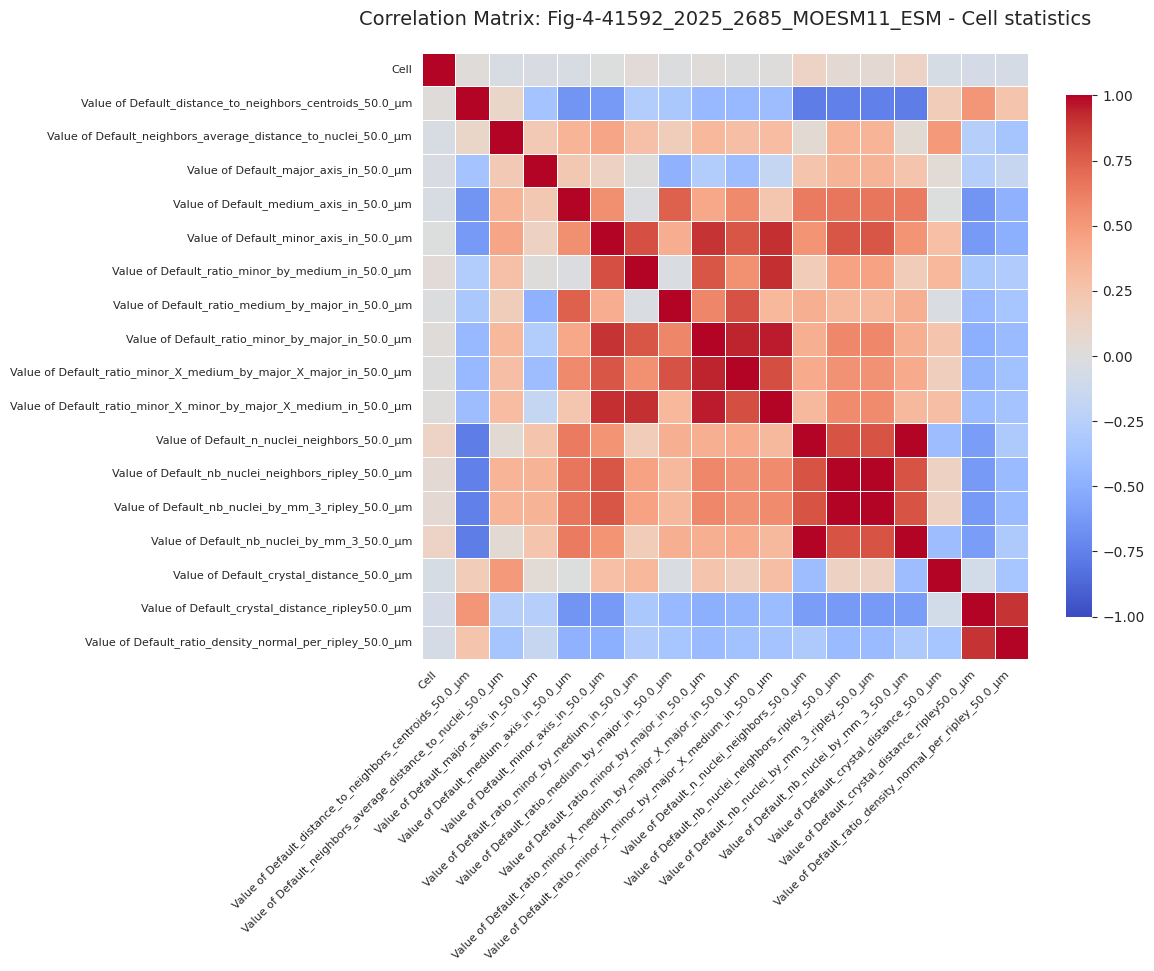


✓ Correlation heatmap saved for Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics


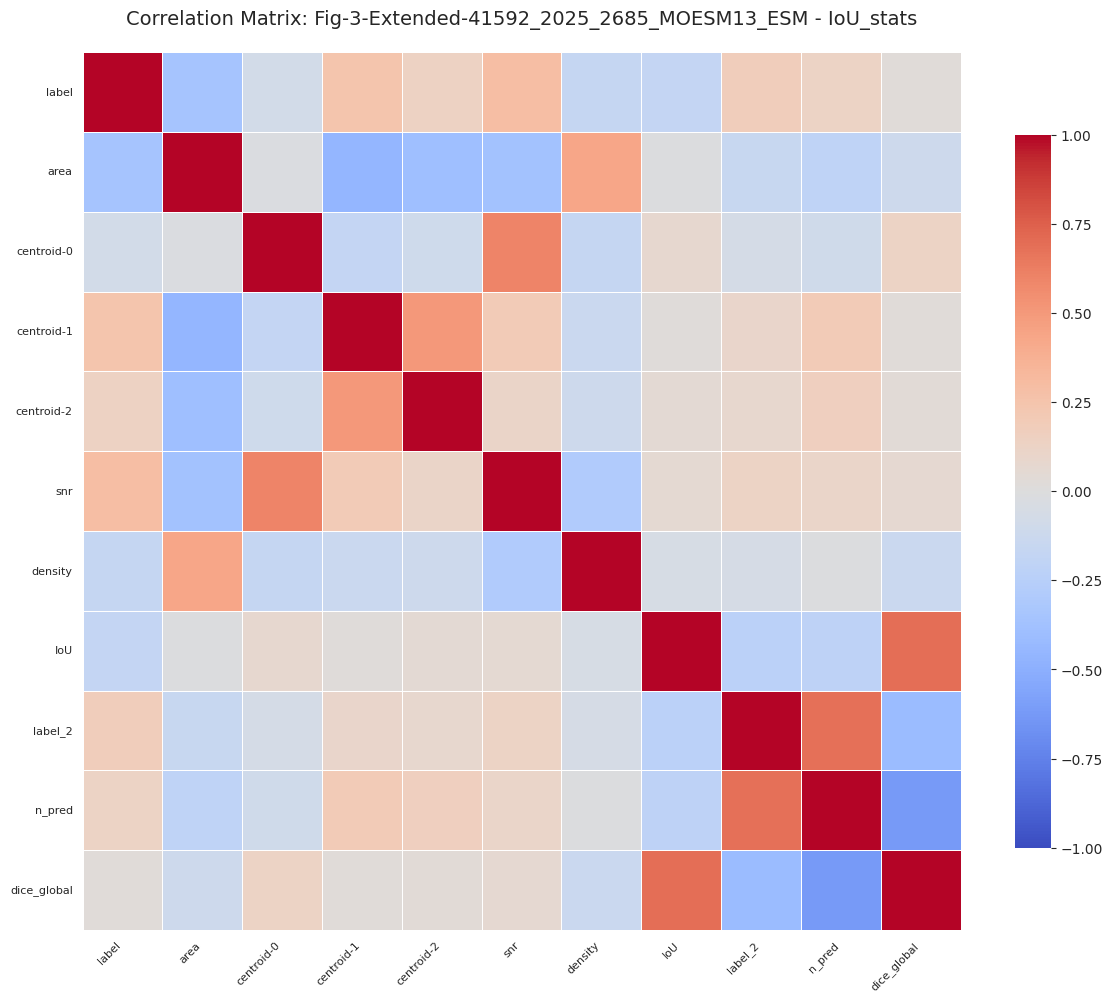


✓ Correlation heatmap saved for Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats


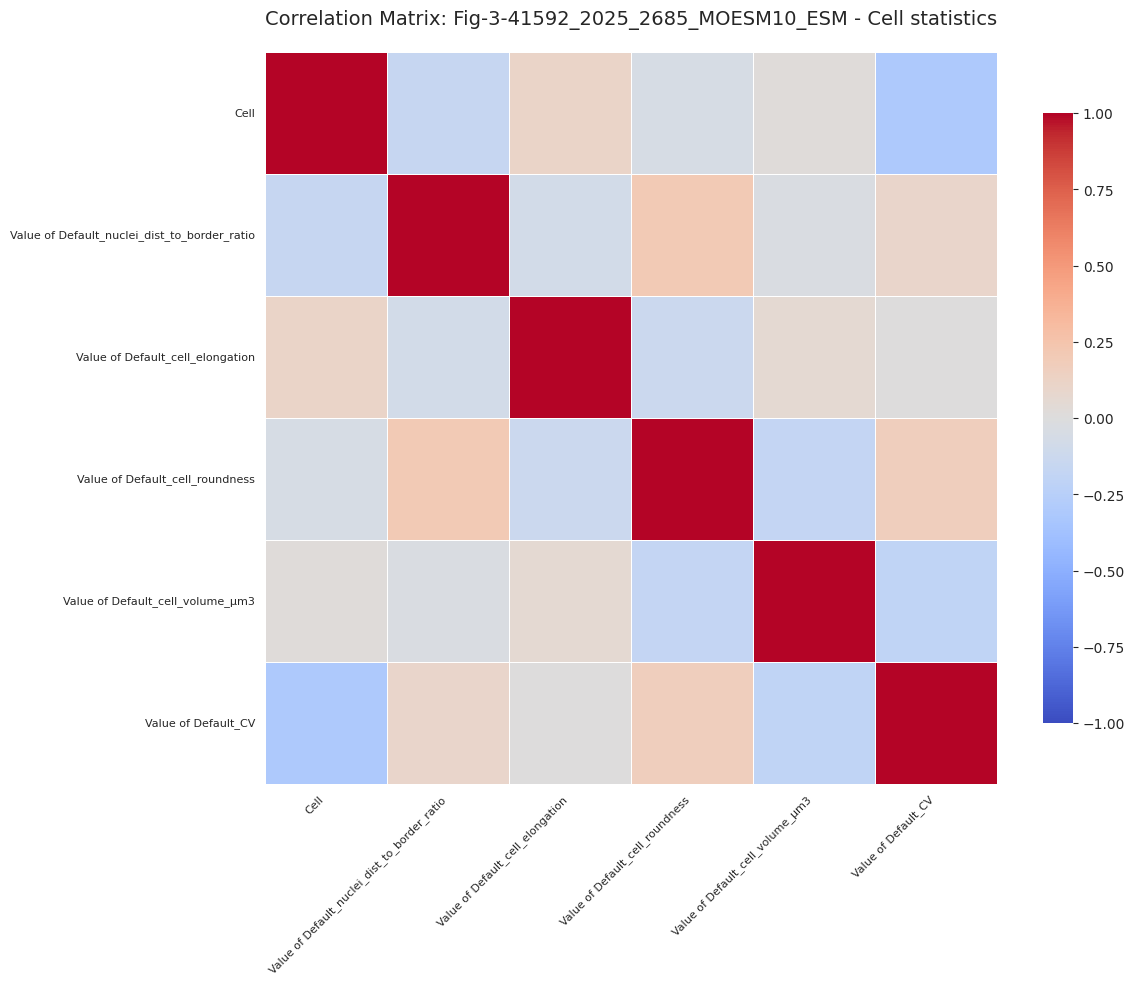


✓ Correlation heatmap saved for Fig-3-41592_2025_2685_MOESM10_ESM - Cell statistics


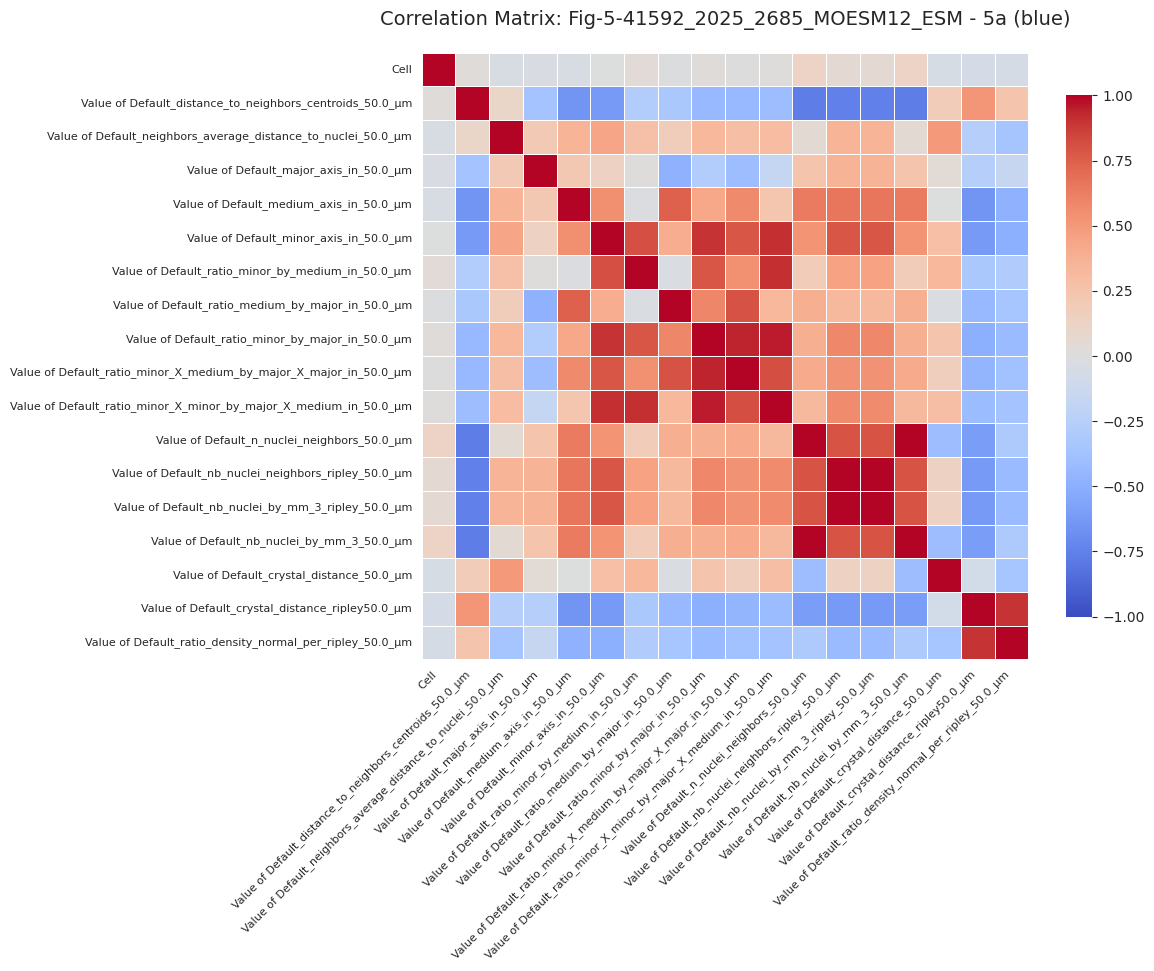


✓ Correlation heatmap saved for Fig-5-41592_2025_2685_MOESM12_ESM - 5a (blue)
⚠ Too many features (30) - showing top 20 by variance


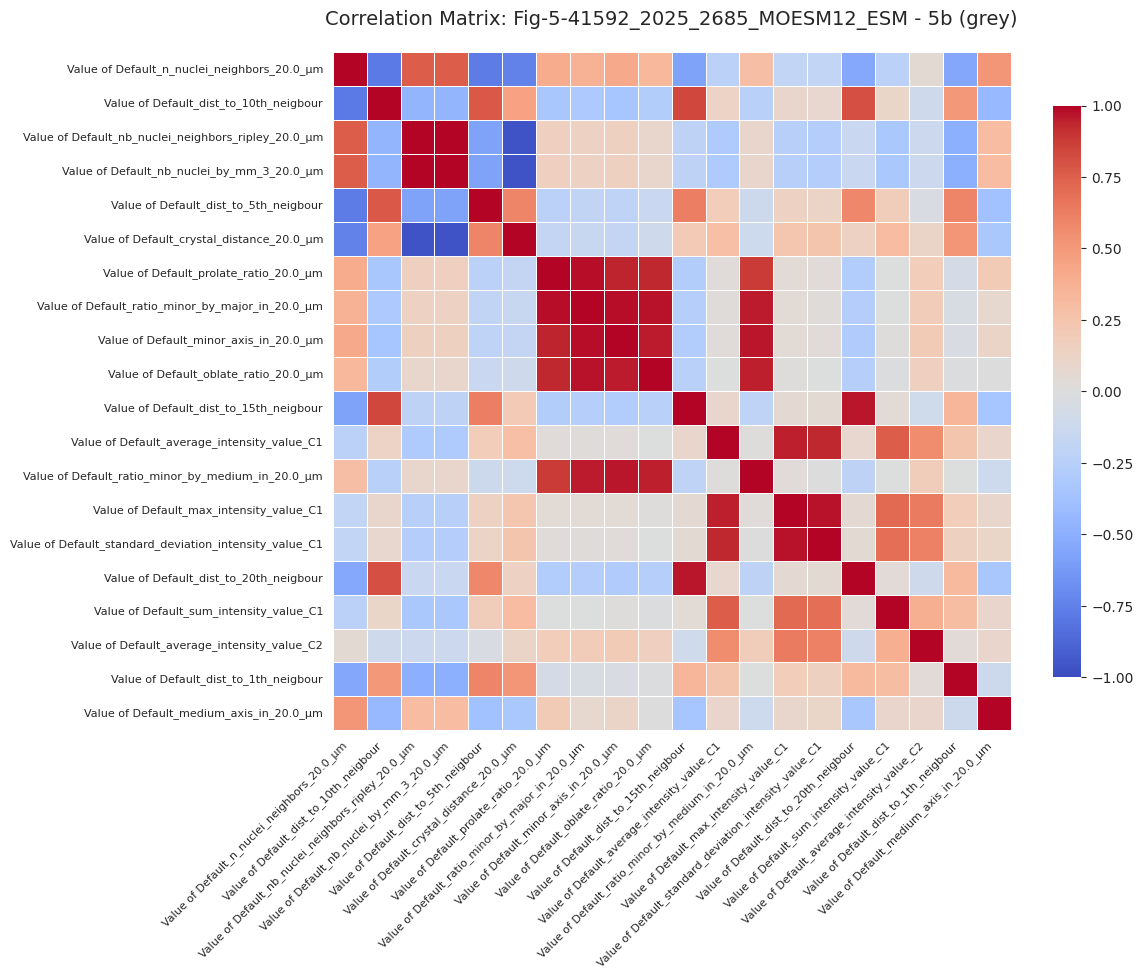


✓ Correlation heatmap saved for Fig-5-41592_2025_2685_MOESM12_ESM - 5b (grey)


In [ ]:
def plot_correlation_heatmap(corr_matrix, dataset_name, figsize=(12, 10)):
    """
    Create a heatmap visualization of the correlation matrix

    Args:
        corr_matrix: pandas DataFrame (correlation matrix)
        dataset_name: string identifier
        figsize: tuple for figure size
    """
    if corr_matrix is None or len(corr_matrix) < 2:
        print(f"⚠ Skipping heatmap for {dataset_name} - insufficient data")
        return

    # Limit to reasonable number of features for visualization
    if len(corr_matrix) > 20:
        print(f"⚠ Too many features ({len(corr_matrix)}) - showing top 20 by variance")
        # Select features with highest variance
        variances = corr_matrix.var().sort_values(ascending=False)
        top_features = variances.head(20).index
        corr_matrix = corr_matrix.loc[top_features, top_features]

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=False,
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1,
    )
    plt.title(f"Correlation Matrix: {dataset_name}", fontsize=14, pad=20)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()

    filename_safe = dataset_name.replace(" - ", "_").replace(" ", "_")
    #plt.savefig(f"correlation_heatmap_{filename_safe}.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f"\n✓ Correlation heatmap saved for {dataset_name}")


# Execute: Plot correlation heatmaps
for dataset_name, corr_matrix in correlation_matrices.items():
    plot_correlation_heatmap(corr_matrix, dataset_name)


# PART 5: DATASET INVENTORY & COMPARISON



Let's create a comprehensive comparison of all our datasets. We want to see
which features are common across datasets, which are unique, and identify
any duplicate datasets.


In [ ]:
def compare_datasets_features(all_data):
    """
    Compare all datasets to identify:
    - Common features across datasets
    - Unique features in each dataset
    - Potential duplicate datasets

    Returns:
        Dictionary with comparison results
    """
    print(f"\n{'='*70}")
    print("CROSS-DATASET FEATURE COMPARISON")
    print(f"{'='*70}")

    # Extract all feature sets
    dataset_features = {}
    for filename, sheets in all_data.items():
        for sheet_name, df in sheets.items():
            dataset_id = f"{filename} - {sheet_name}"
            # Get numeric feature names
            features = set(df.select_dtypes(include=[np.number]).columns)
            dataset_features[dataset_id] = features

    # Find common features across all datasets
    all_feature_sets = list(dataset_features.values())
    common_features = set.intersection(*all_feature_sets) if all_feature_sets else set()

    print(f"\n📊 FEATURES COMMON TO ALL DATASETS ({len(common_features)}):")
    if common_features:
        for feat in sorted(common_features):
            print(f"  - {feat}")
    else:
        print("  (No features common to all datasets)")

    # Find unique features in each dataset
    print(f"\n📊 UNIQUE FEATURES PER DATASET:")
    for dataset_id, features in dataset_features.items():
        other_features = set()
        for other_id, other_feats in dataset_features.items():
            if other_id != dataset_id:
                other_features.update(other_feats)

        unique = features - other_features
        if unique:
            print(f"\n{dataset_id}:")
            print(f"  Unique features ({len(unique)}): {sorted(unique)}")

    # Check for potential duplicates (same features and same row count)
    print(f"\n📊 CHECKING FOR DUPLICATE DATASETS:")
    checked_pairs = set()
    duplicates_found = False

    for id1, feats1 in dataset_features.items():
        for id2, feats2 in dataset_features.items():
            if id1 < id2 and (id1, id2) not in checked_pairs:
                checked_pairs.add((id1, id2))

                # Check if features match
                if feats1 == feats2:
                    # Get dataframes and check row counts
                    df1 = all_data[id1.split(" - ")[0]][id1.split(" - ")[1]]
                    df2 = all_data[id2.split(" - ")[0]][id2.split(" - ")[1]]

                    if df1.shape[0] == df2.shape[0]:
                        print(f"\n⚠ POTENTIAL DUPLICATE DETECTED:")
                        print(f"  {id1}")
                        print(f"  {id2}")
                        print(
                            f"  Both have {df1.shape[0]} rows and {len(feats1)} features"
                        )
                        duplicates_found = True

    if not duplicates_found:
        print("  ✓ No duplicate datasets detected")

    return dataset_features


# Execute: Compare datasets
dataset_features = compare_datasets_features(all_datasets)



CROSS-DATASET FEATURE COMPARISON

📊 FEATURES COMMON TO ALL DATASETS (0):
  (No features common to all datasets)

📊 UNIQUE FEATURES PER DATASET:

Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats:
  Unique features (11): ['IoU', 'area', 'centroid-0', 'centroid-1', 'centroid-2', 'density', 'dice_global', 'label', 'label_2', 'n_pred', 'snr']

Fig-2-41592_2025_2685_MOESM9_ESM - Cell statistics:
  Unique features (2): ['Value of Default_nuclei_dist_to_border_μm', 'Value of Default_nuclei_volume_μm3']

Table-3-Extended-41592_2025_2685_MOESM14_ESM - speed:
  Unique features (1): ['speed']

Fig-3-41592_2025_2685_MOESM10_ESM - Cell statistics:
  Unique features (4): ['Value of Default_CV', 'Value of Default_cell_elongation', 'Value of Default_cell_roundness', 'Value of Default_cell_volume_μm3']

Fig-5-41592_2025_2685_MOESM12_ESM - 5b (grey):
  Unique features (29): ['Value of Default_average_intensity_value_C1', 'Value of Default_average_intensity_value_C2', 'Value of Default_crystal_dist

### Summary Table


Finally, let's create a comprehensive summary table showing key statistics
for each dataset side-by-side. This will be our reference for deciding
which dataset to use for which analysis.


In [ ]:
def create_comprehensive_summary(all_data):
    """
    Create a detailed summary table comparing all datasets

    Returns:
        pandas DataFrame with comprehensive summary
    """
    summary_data = []

    for filename, sheets in all_data.items():
        for sheet_name, df in sheets.items():
            numeric_cols = df.select_dtypes(include=[np.number]).columns

            # Identify hierarchy columns
            well_col = [col for col in df.columns if "well" in col.lower()]
            field_col = [col for col in df.columns if "field" in col.lower()]

            n_wells = df[well_col[0]].nunique() if well_col else "N/A"
            n_fields = df[field_col[0]].nunique() if field_col else "N/A"

            # Calculate missing data percentage
            missing_pct = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100

            summary_data.append(
                {
                    "Dataset": f"{filename} - {sheet_name}",
                    "Total_Cells": df.shape[0],
                    "Total_Features": df.shape[1],
                    "Numeric_Features": len(numeric_cols),
                    "N_Wells": n_wells,
                    "N_Fields": n_fields,
                    "Missing_Data_%": f"{missing_pct:.2f}",
                    "Suggested_Use": "",  # We'll fill this manually based on our knowledge
                }
            )

    summary_df = pd.DataFrame(summary_data)

    print(f"\n{'='*70}")
    print("COMPREHENSIVE DATASET SUMMARY")
    print(f"{'='*70}\n")
    print(summary_df.to_string(index=False))

    # Save to CSV for reference
    summary_df.to_csv("dataset_summary.csv", index=False)
    print(f"\n✓ Summary saved to 'dataset_summary.csv'")

    return summary_df


# Execute: Create comprehensive summary
summary_df = create_comprehensive_summary(all_datasets)


COMPREHENSIVE DATASET SUMMARY

                                               Dataset  Total_Cells  Total_Features  Numeric_Features N_Wells N_Fields Missing_Data_% Suggested_Use
   Fig-4-41592_2025_2685_MOESM11_ESM - Cell statistics         1784              22                18       8        1           0.00              
Fig-3-Extended-41592_2025_2685_MOESM13_ESM - IoU_stats         7788              15                11     N/A      N/A           2.79              
    Fig-2-41592_2025_2685_MOESM9_ESM - Cell statistics          895               9                 4       1        4           0.00              
  Table-3-Extended-41592_2025_2685_MOESM14_ESM - speed           70               4                 1     N/A      N/A           0.00              
   Fig-3-41592_2025_2685_MOESM10_ESM - Cell statistics         2062              11                 6       2        6           0.00              
         Fig-5-41592_2025_2685_MOESM12_ESM - 5a (blue)         1784             

# PART 6: RESEARCH QUESTIONS & TUTORIAL ROADMAP



Based on our exploration, let's formulate specific research questions that
each dataset can answer. This sets up our roadmap for subsequent tutorials.



### Fig-2: Basic nuclear morphology dataset

**Tutorial Assignment:** Tutorial 3 (Basic Analysis & Practice)

**Research Questions:**
1. What is the distribution of nuclear volumes in organoids?
2. How do nuclei vary in position relative to organoid borders?
3. Practice dataset for learning basic statistical operations

---

### Fig-3: Osmotic stress experiment (isotonic vs hypertonic)

**Tutorial Assignment:** Tutorial 4 (Morphology Analysis & Statistics)

**Research Questions:**
1. Does osmotic stress significantly affect cell volume?
2. Do cells become more round or elongated under stress?
3. Is chromatin compaction (CV) increased in stressed cells?
4. Are effects consistent across all imaging fields?

---

### Fig-4: Spatial topology features across conditions

**Tutorial Assignment:** Tutorial 5 (Topology + Machine Learning)

**Research Questions:**
1. How do different culture conditions affect spatial organization?
2. Which topology features best distinguish experimental groups?
3. Can we predict sample type from spatial features alone?
4. Which features are redundant and can be removed?

---

### Fig-5a: Duplicate of Fig-4

**Tutorial Assignment:** Skip (duplicate)

**Note:** Verified identical to Fig-4. Use Fig-4 for analysis.

---

### Fig-5b: Single large PDAC organoid with spatial heterogeneity

**Tutorial Assignment:** Tutorial 6 (Heterogeneity + ML Discovery)

**Research Questions:**
1. Can we identify distinct cellular regions (core/border/buds)?
2. What features distinguish cells in different spatial zones?
3. Does unsupervised clustering reveal biological regions?
4. Can we build a classifier to predict cell region?

---

## NEXT STEPS

**Tutorial 2 Complete:** We have systematically explored all datasets

**Tutorial 3: Basic Statistical Analysis**
- Dataset: Fig-2 (Basic morphology)
- Methods: Descriptive statistics, distributions, basic visualization
- Central Question: Understanding nuclear morphology patterns

**Tutorial 4: Morphology Analysis**
- Dataset: Fig-3 (Osmotic Stress)
- Methods: Statistical testing, effect sizes, visualization
- Central Question: Does osmotic stress alter cell morphology in 3D?

**Tutorial 5: Topology + ML Classification**
- Dataset: Fig-4 (Spatial Organization)
- Methods: Random Forest, XGBoost, feature importance
- Central Question: Can we predict conditions from spatial features?

**Tutorial 6: Heterogeneity + ML Discovery**
- Dataset: Fig-5b (Single PDAC Organoid)
- Methods: K-means, UMAP, SHAP values
- Central Question: What are the distinct regions in a tumor organoid?

---